<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº3: Análisis de Fourier: FFT, desparramo, interpolación y ventaneo
#### María Victoria Poric

## Introducción teórica

El Procesamiento Digital de Señales(DSP) es un campo fundamental que ofrece ventajas significativas sobre el procesamiento analógico. Se ocupa de transformar señales discretas en el tiempo utilizando sistemas que operan sobre ellas. 

Para el estudio de DSP los sistemas lineales invariantes en el tiempo son centrales. Estos se caracterizan por su respuesta al impulso $h[n]$ en el dominio del tiempo. La respuesta de un sistema LTI a cualquier entrada puede calcularse mediante la operación de convolución entre la señal de entrada y la respuesta al impulso. Sin embargo, el análisis de estos sistemas y señales se simplifica en gran medida al pasar al dominio de la frecuencia. 

La Transformada de Fourier de Tiempo Discreto(DTFT) es la herramienta teórica para analizar señales y sistemas LTI en el dominio de la frecuencia. La DTFT de la respuesta al impulso de un sistema LTI se denomina respuesta en frecuencia, $H(\omega)$ y describe cómo el sistema atenúa o amplifica los diferentes componentes de frecuencia y cómo desplaza su fase. Para sistemas LTI definidos por ecuaciones de diferencia lineales con coeficientes constantes, la respuesta en frecuencia puede calcularse como la razón de polinomios en exponenciales complejas, lo que permite una caracterización completa del comportamiento del filtro.

Como el cálculo de la DTFT en una computadora digital resulta complicado, se utiliza la Transformada Discreta de Fourier(DFT) y su implementación eficiente, la Transformada Rápida de Fourier(FFT). Esto introduce el ventaneo de datos(data windowing) y el muestreo en frecuencia(frequency sampling). 

El proceso de truncar una señal mediante una ventana de datos provoca la fuga espectral(spectral leakage) donde la energía de una frecuencia específica se "desparrama" a frecuencias adyacentes en el espectro. Esto se debe a la convolución del espectro ideal de la señal con el espectro de la ventana. La resolución espectral, es decir, la capacidad de distinguir dos componentes de frecuencias cercanas, está directamente ligada al ancho del lóbulo principal del espectro de la ventana. Técnicas como el zero padding pueden mejorar la visualización del espectro, interpolando la DTFT subyacente, pero no aumentan la resolución espectral inherente al segmento de señal original. 

El periodograma es un estimador no paramétrico de la densidad espectral de potencia(PSD), que permite estimar las características de frecuencia de una señal a partir de segmentos de datos de longitud finita. La Identidad de Parseval es crucial para verificar la consistencia de estas mediciones, ya que establece que la energía total de una señal en el dominio del tiempo es igual a la energía total de sus componentes en el dominio de la frecuencia.

## Análisis y desarrollo

Para comenzar se procedió con el siguiente código

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

# --- Parámetros de la simulación ---
N = 1000  # Número de muestras
fs = N    # Frecuencia de muestreo (Hz). Elegida para que df=1 Hz
df = fs / N # Resolución de frecuencia (Hz). Aquí df = 1 Hz
ts = 1 / fs # Período de muestreo (s)

# --- Función para generar senoidales ---
def sen(frec, num_muestreo, amp=1, dc=0, ph=0, frec_muestreo=None):
    if frec_muestreo is None:
        raise ValueError("sampling_freq debe ser proporcionada.")
    
    n_indices = np.arange(num_muestreo)
    t = n_indices / frec_muestreo
    x = dc + amp * np.sin(2 * np.pi * frec * t + ph)
    return t, x

# --- Generación de las senoidales según la consigna ---

# Para obtener potencia promedio unitaria (A^2/2 = 1 => A = sqrt(2))
amplitud = np.sqrt(2) 

# Senoidal 1: k0 = N/4 (frecuencia sintonizada con un bin de la DFT)
# frec = k0 * df = (N/4) * (fs/N) = fs/4
k0_1 = N / 4
frec1 = k0_1 * df
t1, x1 = sen(frec=frec1, num_muestreo=N, amp=amplitud, frec_muestreo=fs)

# Senoidal 2: k0 = N/4 + 0.25 (frecuencia desintonizada)
k0_2 = N / 4 + 0.25
frec2 = k0_2 * df
t2, x2 = sen(frec=frec2, num_muestreo=N, amp=amplitud, frec_muestreo=fs)

# Senoidal 3: k0 = N/4 + 0.5 (frecuencia desintonizada, pico entre bins, máxima fuga)
k0_3 = N / 4 + 0.5
frec3 = k0_3 * df
t3, x3 = sen(frec=frec3, num_muestreo=N, amp=amplitud, frec_muestreo=fs)

En primer lugar se dieron los parámetros de simulación, en este caso 1000 muestras. Luego, se procedió con la función de señales senoidales, ya utilizada previamente en otras tareas. Como se pide una potencia unitaria se utiliza como parámetro de amplitud el número $\sqrt 2$. A continuación, se generan las funciones requeridas. Para la primera señal senoidal la frecuencia es $N/4$, para la segunda señal es $N/4 + 0.25$ y para la tercera es $N/4 + 0.5$. 

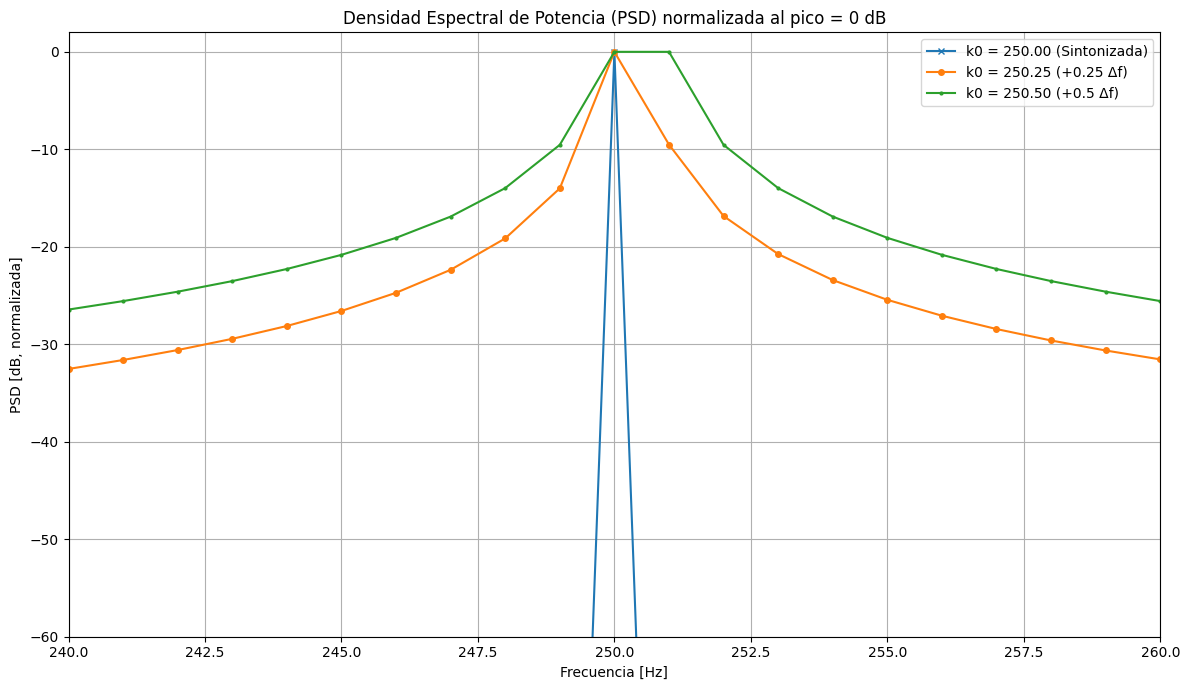

In [8]:
# --- Cálculo de la DFT y la Densidad Espectral de Potencia (PDS) ---
# Se grafica en escala de decibelios (dB) usando 10 * log10(PDS)

# =======================================
# Función de PSD normalizada al pico (0 dB)
# =======================================
def psd_normalizada(x, fs):
    N = len(x)
    X = fft(x)
    P = np.abs(X)**2
    # nos quedamos con mitad positiva
    P = P[:N//2 + 1]
    P[1:-1] *= 2        # para energía de una sola cara
    P /= np.max(P)       # normalización al pico = 1
    P_dB = 10 * np.log10(P + 1e-15)
    freqs = np.linspace(0, fs/2, N//2 + 1)
    return freqs, P_dB

# =======================================
# Cálculo de las PSD
# =======================================
ff1, P1_dB = psd_normalizada(x1, fs)
ff2, P2_dB = psd_normalizada(x2, fs)
ff3, P3_dB = psd_normalizada(x3, fs)

# =======================================
# Gráfico principal: efecto de desintonización
# =======================================
plt.figure(figsize=(12, 7))
plt.plot(ff1, P1_dB, 'x-', markersize=4, label=f'k0 = {k0_1:.2f} (Sintonizada)')
plt.plot(ff2, P2_dB, 'o-', markersize=4, label=f'k0 = {k0_2:.2f} (+0.25 Δf)')
plt.plot(ff3, P3_dB, '.-', markersize=4, label=f'k0 = {k0_3:.2f} (+0.5 Δf)')
plt.title("Densidad Espectral de Potencia (PSD) normalizada al pico = 0 dB")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB, normalizada]")
plt.xlim([frec1 - 10, frec1 + 10])
plt.ylim([-60, 2])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Para el cálculo de la Densidad Espectral de Potencia se utilizó la fórmula $$P[k]=\frac{1}{N}|X[k]|^2$$ siendo $X[k]$ la respectiva Transformada Rápida de Fourier(FFT). 

Se utiliza la función *psd_normalizada* donde en primer lugar se calcula la transformda de Fourier de la señal y luego el espectro de potencia discreto, es decir, la energía que aporta cada componente de frecuencia. Como la señal es real, el espectro de la FFT es simétrico por ende sólo se toma el lado positivo, desde 0 Hz hasta $fs/2$(frecuencia de Nyquist). Como se descarta la mitad negativa, se duplican los valores(excepto los extremos) para conservar la energía total. A continuación se normaliza la energía, es decir, se divide todo el espectro por el valor máximo, el bin con mayor energía pasa a valer 1. Por último, se convierte todo a decibelios y se genera el vector de frecuencias. 

Respecto al efecto de desintonía se puede decir, en primer lugar para la frecuencia sintonizada($k0 = N / 4$) al ser un múltiplo exacto de $\Delta f$, es decir, que $k0$ es un entero, el espectro muestra un pico muy nítido y localizado en la frecuencia esperada, ya que la energía se concentra casi por completo en ese bin de frecuencia específico. Esto se debe a que la duración de la señal contiene un número entero de ciclos de la senoidal, y los puntos de la DFT "caen" directamente en un bin de frecuencia. Para los casos de frecuencias desintonizadas($k0 = N / 4 + 0.25$ y $k0 = N / 4 + 0.5$) no coinciden exactamente con un bin de la DFT. Esto provoca el fenómeno de fuga espectral. En lugar de un pico nítido, la energía se "desparrama" a los bins de frecuencia adyacentes, formando un lóbulo principal más ancho y lóbulos laterales de menor amplitud. Para la segunda frecuencia, al ser 250.25 Hz y siendo que la DFT sólo muestra valores de amplitud del espectro en sus bins discretos(250 Hz, 251 Hz, etc), la mayor concentración de energía muestreada cae en el bin más cercano, en este caso 250 Hz, es por ello que "el pico" se observa en el mismo lugar que la primera frecuencia. En el caso de la última frecuencia, representa la máxima desintonía, ya que la frecuencia cae exactamente a la mitad de dos bins. Entonces la fuga espectral es más pronunciada, y la energía se distribuye de manera más uniforme entre los dos bins centrales, reduciendo la altura del pico principal y elevando los lóbulos laterales en comparación con la señal sintonizada.

In [9]:
# --- Verificación de potencia unitaria con Parseval ---
def verificar_potencia(x, X, N):
    # Potencia en el dominio temporal
    pot_tiempo = np.sum(np.abs(x)**2) / N
    # Potencia en el dominio frecuencial
    pot_frecuencia = np.sum(np.abs(X)**2) / (N**2)
    return pot_tiempo, pot_frecuencia

X1 = fft(x1)
X2 = fft(x2)
X3 = fft(x3)

# Verificar cada senoidal
p1_t, p1_f = verificar_potencia(x1, X1, N)
p2_t, p2_f = verificar_potencia(x2, X2, N)
p3_t, p3_f = verificar_potencia(x3, X3, N)

print("\n--- Verificación de Parseval ---")
print(f"Senoidal 1 (k0=N/4):        Pot_tiempo={p1_t:.4f}, Pot_freq={p1_f:.4f}")
print(f"Senoidal 2 (k0=N/4+0.25):  Pot_tiempo={p2_t:.4f}, Pot_freq={p2_f:.4f}")
print(f"Senoidal 3 (k0=N/4+0.5):   Pot_tiempo={p3_t:.4f}, Pot_freq={p3_f:.4f}")


--- Verificación de Parseval ---
Senoidal 1 (k0=N/4):        Pot_tiempo=1.0000, Pot_freq=1.0000
Senoidal 2 (k0=N/4+0.25):  Pot_tiempo=0.9990, Pot_freq=0.9990
Senoidal 3 (k0=N/4+0.5):   Pot_tiempo=1.0000, Pot_freq=1.0000


Para el ítem b de este tarea se definió una función para verificar la potencia, donde *pot_tiempo* calcula la potencia promedio de la señal en el dominio del tiempo, dado que la amplitud se fijó en $\sqrt 2$ debería ser $1$, y *pot_frecuencia* calcula la potencia en el dominio frecuencial. 

La identidad de Parseval para la DFT establece que $$\sum_{n=0}^{N-1} |x[n]|^2 \;=\; \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2$$ Si $$\text{pot\_tiempo} \;=\; \frac{1}{N} \sum_{n=0}^{N-1} |x[n]|^2$$ entonces para que *pot_frecuencia* sea directamente comparable a *pot_tiempo* según Parseval, debería ser $$\frac{1}{N} \cdot \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2 \;=\; \frac{1}{N^2} \sum_{k=0}^{N-1} |X[k]|^2$$. Se espera y se obtienen valores cercanos a $1.0$ comprobando la identidad.

La razón por la cual una señal senoidal tiene un espectro diferente respecto a otra con una mínima diferencia de Hertz se debe a la resolución espectral y el efecto del ventaneo en el análisis de la Transformada Discreta de Fourier(DFT). Una senoidal de duración infinita tiene un espectro ideal que consiste en dos impulsos de Dirac a $\pm \omega_0$, es decir que su energía está concentrada ahí. En las prácticas, siempre se analizaron segmentos de señal de duración finita, esto equivale a multiplicar la señal infinita por una ventana de datos(en este caso la ventana rectangular). La multiplicación en el dominio del tiempo se traduce en una convolución en el dominio de la frecuencia entre el espectro ideal de la señal y el espectro de la ventana(función sinc periódica). Esta convolución reemplaza los impulsos puros con el lóbulo principal y los lóbulos laterales de la función sinc, esto es la fuga espectral. La energía se "fuga" de la frecuencia original a las frecuencias adyacentes. La resolución espectral es la capacidad de distinguir dos componentes de frecuencia cercanas, depende directamente del ancho del lóbulo principal del espectro de la ventana, que es inversamente proporcional a la longitud de la ventana N. Si la diferencia de frecuencia entre dos senoidales es mayor que el ancho del lóbulo principal de la ventana, sus picos se verán como dos entidades separadas. Si es menor, los lóbulos principales de ambas senoidales se solapan y se fusionan, esto hace que las dos señales aparezcan como un único pico ancho y ambiguo en el espectro. Por lo tanto, una pequeña diferencia de Hertz puede llevar a espectros que parecen "muy diferentes" porque la resolución inherente al análisis(determinada por la duración de la observación y la ventana) no es suficiente para separarlas. El código demuestra esto con la desintonía de $0.25 \quad \text{o} \quad 0.5 \Delta f$ causa un "ensanchamiento" significativo del pico. 

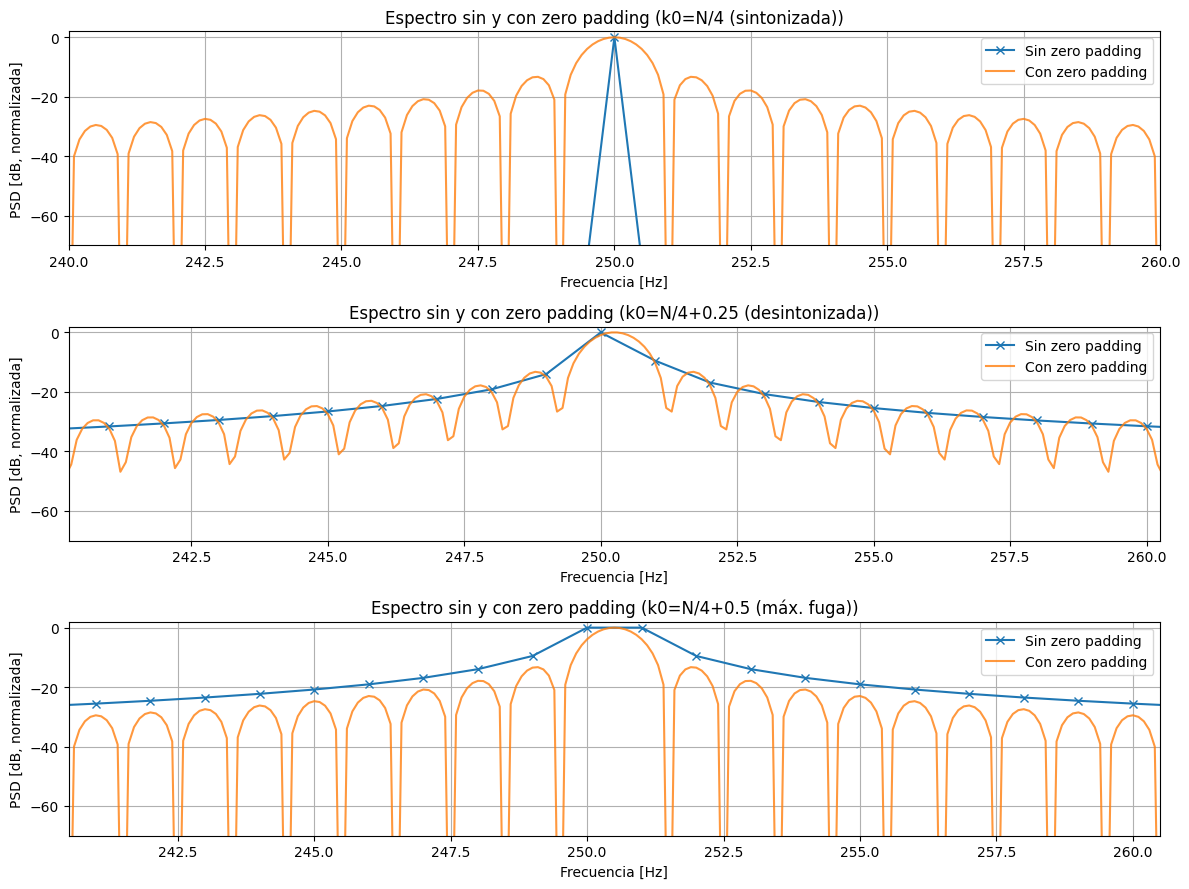

In [10]:
# --- Zero padding: agregar 9*N ceros (total 10*N) ---
Npad = 10 * N

plt.figure(figsize=(12, 9))
for i, (f0, lbl) in enumerate(zip(
    [frec1, frec2, frec3],
    ["k0=N/4 (sintonizada)", "k0=N/4+0.25 (desintonizada)", "k0=N/4+0.5 (máx. fuga)"]
), 1):
    
    n = np.arange(N)
    x = amplitud * np.sin(2*np.pi * f0 * n / fs)

    # sin zero padding
    freqs, P_dB = psd_normalizada(x, fs)

    # con zero padding
    x_pad = np.concatenate([x, np.zeros(Npad - N)])
    freqs_pad, P_pad_dB = psd_normalizada(x_pad, fs)

    plt.subplot(3, 1, i)
    plt.plot(freqs, P_dB, 'x-', label="Sin zero padding")
    plt.plot(freqs_pad, P_pad_dB, '-', alpha=0.8, label="Con zero padding")
    plt.title(f"Espectro sin y con zero padding ({lbl})")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("PSD [dB, normalizada]")
    plt.xlim([f0 - 10, f0 + 10])
    plt.ylim([-70, 2])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

Para el ítem c, el código define $Npad = 10 \cdot N$ lo que significa que se agregan $9 \cdot N$ muestras. Para cada una de las tres senoidales originales se crea una versión *x_pad* concatenando la señal original x con un vector de ceros. Y luego se calcula las PDS correspondiente. Y por último, se grafican la PDS original y con zero padding. 

La adición de ceros al final de la señal en el dominio del tiempo(*x_pad*) no agrega nueva información temporal a la señal. Sin embargo, al aumentar la longitud de la señal a *Npad*, el tamaño de la DFT se incrementa. Esto resulta en una mayor cantidad de puntos de frecuencia en el espectro discreto, lo que reduce la resolución de frecuencia discreta($\Delta \text{f\_pad} = fs / Npad = (fs / N) / 10 = \Delta f / 10$). El zero padding no mejora la resolución espectral verdadera de la señal sino que proporciona una interpolación del espectro. Al tener más puntos en el dominio de la frecuencia, la forma contínua de la DTFT de la señal se muestra con más densidad. Visualmente, es un espectro más suave y detallado. En el caso de las frecuencias desintonizados, el pico que antes aparecía un solo bin ancho o como la suma de la energía en dos bins adyacentes, con zero padding se mostrará como una curva más continua que revela la forma del lóbulo principal y dónde se encuentra el verdadero pico de la DTFT, aunque la frecuencia "verdadera" no haya sido un bin DFT. 

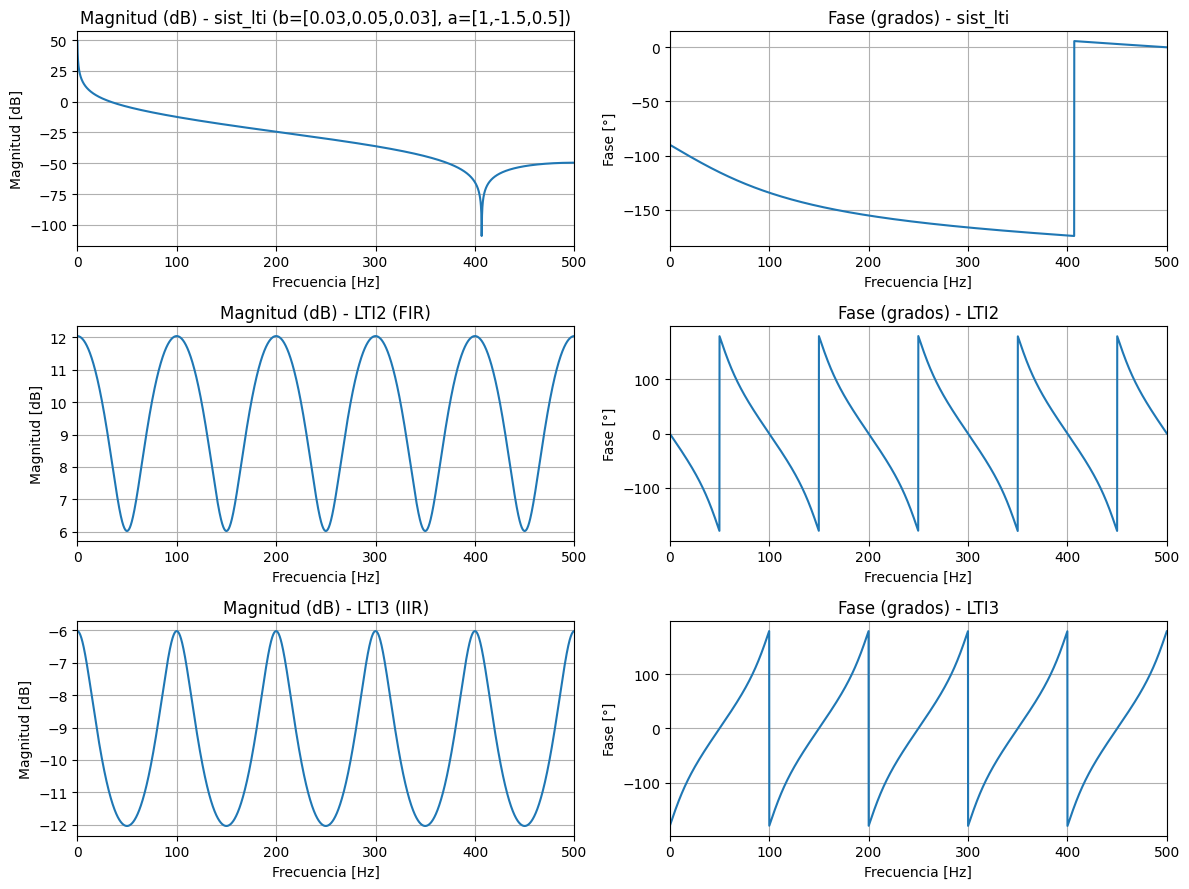

In [13]:
# BONUS

import warnings
from scipy.signal import freqz

# -----------------------------
# Respuesta en frecuencia de los sistemas
# -----------------------------
fs = N    # ya lo tenías (fs = N para que df = 1 Hz)
w_points = 4096  # resolución en el eje frecuencia para freqz

# 1) Sistema de sist_lti: b = [e0,e1,e2], a = [1, -r0, -r1]
b_sist = np.array([0.03, 0.05, 0.03])
r0, r1 = 1.5, -0.5
a_sist = np.array([1.0, -r0, -r1])  # nota el signo por la forma de la ecuación en tu código

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    w, H = freqz(b_sist, a_sist, worN=w_points)
freqs_hz = w * fs / (2 * np.pi)

# 2) LTI2: FIR b = e (length 11), a = [1]
e_LTI2 = np.zeros(11)
e_LTI2[0] = 1.0
e_LTI2[10] = 3.0
b_lti2 = e_LTI2
a_lti2 = np.array([1.0])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    w2, H2 = freqz(b_lti2, a_lti2, worN=w_points)
freqs_hz2 = w2 * fs / (2 * np.pi)

# 3) LTI3: IIR with a (length 11), b = [1]
a_LTI3 = np.zeros(11)
a_LTI3[0] = 1.0
a_LTI3[10] = -3.0
b_lti3 = np.array([1.0])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    w3, H3 = freqz(b_lti3, a_LTI3, worN=w_points)
freqs_hz3 = w3 * fs / (2 * np.pi)

# -----------------------------
# Graficar magnitud (dB) y fase (grados)
# -----------------------------
plt.figure(figsize=(12, 9))

# SIST_LTI
plt.subplot(3,2,1)
plt.plot(freqs_hz, 20*np.log10(np.abs(H)+1e-15))
plt.title("Magnitud (dB) - sist_lti (b=[0.03,0.05,0.03], a=[1,-1.5,0.5])")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid()
plt.xlim(0, fs/2)

plt.subplot(3,2,2)
plt.plot(freqs_hz, np.angle(H, deg=True))
plt.title("Fase (grados) - sist_lti")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Fase [°]")
plt.grid()
plt.xlim(0, fs/2)

# LTI2 (FIR)
plt.subplot(3,2,3)
plt.plot(freqs_hz2, 20*np.log10(np.abs(H2)+1e-15))
plt.title("Magnitud (dB) - LTI2 (FIR)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid()
plt.xlim(0, fs/2)

plt.subplot(3,2,4)
plt.plot(freqs_hz2, np.angle(H2, deg=True))
plt.title("Fase (grados) - LTI2")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Fase [°]")
plt.grid()
plt.xlim(0, fs/2)

# LTI3 (IIR)
plt.subplot(3,2,5)
plt.plot(freqs_hz3, 20*np.log10(np.abs(H3)+1e-15))
plt.title("Magnitud (dB) - LTI3 (IIR)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid()
plt.xlim(0, fs/2)

plt.subplot(3,2,6)
plt.plot(freqs_hz3, np.angle(H3, deg=True))
plt.title("Fase (grados) - LTI3")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Fase [°]")
plt.grid()
plt.xlim(0, fs/2)

plt.tight_layout()
plt.show()

Para el punto Bonus, la respuesta en frecuencia $H(\omega)$ es la Transformada de Fourier de Tiempo Discreto(DTFT) de su respuesta al impulso $h[n]$. Esta función caracteriza el sistema en el dominio de la frecuencia. Para sistemas de ecuaciones de diferencia con coeficientes $b\_k$(numerador) y $a\_k$(denominador), la respuesta en frecuencia se calcula como: $$H(\omega) = \frac{\displaystyle \sum_{k=0}^{M} b_k \, e^{-j \omega k}} 
{\displaystyle \sum_{k=0}^{N} a_k \, e^{-j \omega k}}$$ La función *scipy.signal.freqz* está diseñada para calcular esta respuesta en frecuencia, tomando los coeficientes del numerador($b$) y del denominador($a$) como entrada. 

Luego en el código se definen cada uno de los sistemas usados en la TS2. A continuación, se calcula $H(\omega)$ para cada sistema mediante *freqz* y se las convierte a Hz, ya que son frecuencias angulares. Por último se grafica la magnitud en dB y la fase en grados para cada sistema LTI. 

Se agrega una parte de código de warnings ya que Jupyter Notebook presentaba problemas cuando *freqz* divide por cero o polos fuera del círculo. Con esto se pide que ignore estos warnings. 

## Conclusiones

Para concluir, en este trabajo hemos confirmado que la respuesta en frecuencia $H(\omega)$ de un sistema LTI, calculada a partir de sus coeficientes del numerador y denominador, proporciona una descripción completa de cómo el sistema interactúa con las diferentes componentes de frecuencia de una señal, afectando tanto su magnitud como su fase. 

El experimento con señales senoidales y la Densidad Espectral de Potencia(PSD) ilustró de manera contundente los desafíos prácticos del análisis espectral. La Identidad de Parseval permitió verificar que la energía de una señal se conserva entre el dominio del tiempo y el dominio de la frecuencia. 

También se ha observado cómo la fuga espectral dispersa la energía de las frecuencias fuera de sus bins ideales. Esto sucede cuando las frecuencias de las senoidales no coinciden exactamente con los bins de la DFT, haciendo que dos señales con una diferencia mínima de Hertz parezcan tan diferentes en el espectro. Esto se debe a la limitada resolución espectral del análisis, que es restringida por la duración finita de la señal observada. 

Finalmente, la aplicación del zero padding demostró su utilidad no para aumentar la resolución inherente de las frecuencias reales presentes en la señal, sino para mejorar la visualización y el muestreo de la DTFT subyacente. 

## Autoevaluación del aprendizaje

En el caso de esta tarea creo que los conceptos me quedaron bastante bien asentados. Gracias a que desarrollamos estos temas durante varias clases se me facilitó la implementación del código y poder explicar que estaba haciendo. 
Utilicé IA para alguna corrección o emprolijando el código y utilicé el Holton para la parte teórica. 